## Dependencies

In [73]:
import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from src.dataSampling import SequenceGenerator

## Loading data

In [74]:
data = pd.read_csv('./data/hpq.us.txt')

In [75]:
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1970-01-02,0.30627,0.30627,0.30627,0.30627,2441124,0
1,1970-01-05,0.30627,0.31768,0.30627,0.31385,6219848,0
2,1970-01-06,0.31385,0.31385,0.30996,0.30996,4447522,0
3,1970-01-07,0.31385,0.31385,0.31385,0.31385,1872638,0
4,1970-01-08,0.31385,0.31768,0.31385,0.31385,4280330,0


## Data exploration

In [76]:
data = data.sort_values('Date')


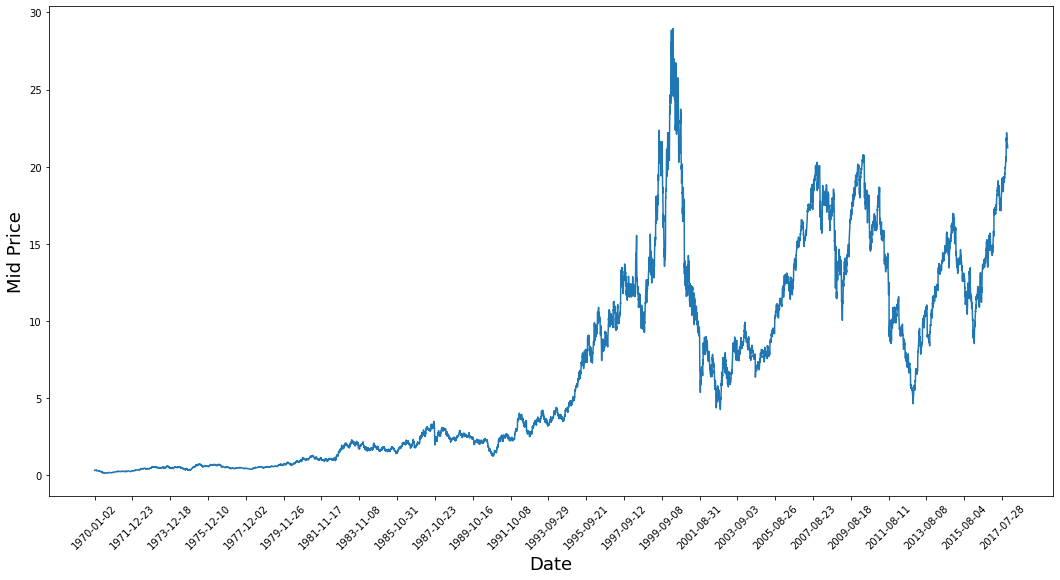

In [77]:
plt.figure(figsize=(18,9))

plt.plot(range(data.shape[0]),(data['High']+data['Low'])/2)
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)

plt.show()

In [78]:
data.pop("Date")
data.pop("OpenInt")

train_df = data.iloc[:round(0.8*data.shape[0])]
test_df = data.iloc[round(0.8*data.shape[0]):]

## Spliting data

In [79]:
high_prices = data.loc[:,'High'].values
low_prices = data.loc[:,'Low'].values

mid_prices = (high_prices+low_prices) / 2.0

In [80]:
mid_prices

array([ 0.30627 ,  0.311975,  0.311905, ..., 21.355   , 21.275   ,
       21.225   ])

In [81]:
mid_prices.shape

(12075,)

In [82]:
train_data = mid_prices[:round(0.8*mid_prices.shape[0])]
test_data = mid_prices[round(0.8*mid_prices.shape[0]):]

In [83]:
train_data.shape

(9660,)

In [84]:
test_data.shape

(2415,)

### Normalizing data

In [85]:
scaler = MinMaxScaler()

train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [86]:
train_data[:10]

array([[0.30627 ],
       [0.311975],
       [0.311905],
       [0.31385 ],
       [0.315765],
       [0.315765],
       [0.32151 ],
       [0.32534 ],
       [0.32151 ],
       [0.32534 ]])

In [87]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [88]:
wide_window = SequenceGenerator(
    input_width=24,
    label_width=24, 
    shift=1,
    train_df=train_df,
    test_df=test_df,
    label_column=['High','Low','Open','Close'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['High', 'Low', 'Open', 'Close']

## Build and Test the model

### LSTM

In [89]:
model = tf.keras.models.Sequential([
    
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [90]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  
  early_stopping = tf.keras.callbacks.EarlyStopping(
    
    monitor='val_loss',
    patience=patience,
    mode='min'
  )

  model.compile(
    
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
  )

  history = model.fit(
    
    window.train, 
    epochs=MAX_EPOCHS,
    validation_data=window.test,
    callbacks=[early_stopping]
  )
  
  return history

## Train the model

In [91]:
history = compile_and_fit(model,window=wide_window)

Epoch 1/20
302/302 [==============================] - 8s 17ms/step - loss: 0.0511 - mean_absolute_error: 0.1080 - val_loss: 0.0256 - val_mean_absolute_error: 0.0890
Epoch 2/20
302/302 [==============================] - 5s 16ms/step - loss: 0.0072 - mean_absolute_error: 0.0431 - val_loss: 0.0087 - val_mean_absolute_error: 0.0579
Epoch 3/20
302/302 [==============================] - 5s 15ms/step - loss: 0.0032 - mean_absolute_error: 0.0298 - val_loss: 0.0043 - val_mean_absolute_error: 0.0425
Epoch 4/20
302/302 [==============================] - 5s 16ms/step - loss: 0.0020 - mean_absolute_error: 0.0236 - val_loss: 0.0033 - val_mean_absolute_error: 0.0382
Epoch 5/20
302/302 [==============================] - 5s 16ms/step - loss: 0.0015 - mean_absolute_error: 0.0203 - val_loss: 0.0031 - val_mean_absolute_error: 0.0369
Epoch 6/20
302/302 [==============================] - 5s 16ms/step - loss: 0.0013 - mean_absolute_error: 0.0188 - val_loss: 0.0029 - val_mean_absolute_error: 0.0357
Epoch 7/20

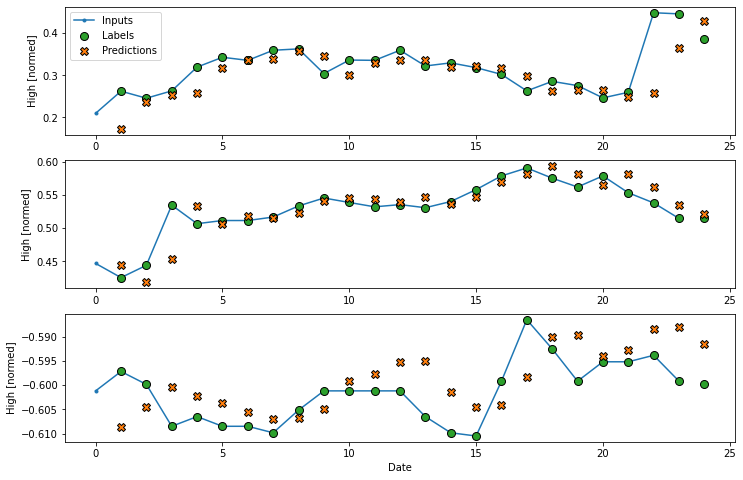

In [95]:
wide_window.plot(model=model,plot_col='High')